Fast Neural Style
=========

Corresponding paper: [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](http://arxiv.org/abs/1603.08155)

Models trained in PyTorch using https://github.com/clcarwin/examples/tree/master/fast_neural_style and `batch_norm` folded into convolutional layers for speed.

In [84]:
import hickle as hkl
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import requests
import numpy as np
from StringIO import StringIO
import torchnet as tnt
import matplotlib.pyplot as plt
from visualize import make_dot
import cv2
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline

## PyTorch model definition

In [75]:
def f(o, params):
    def g(f, x, name, stride=1, padding=0):
        return f(x, params['%s.weight'%name], params['%s.bias'%name], stride, padding)
    o = F.relu(g(F.conv2d, o, 'c1', 1, 4))
    o = F.relu(g(F.conv2d, o, 'c2', 2, 1))
    o = F.relu(g(F.conv2d, o, 'c3', 2, 1))
    for i in range(1, 6):
        o += g(F.conv2d, F.relu(g(F.conv2d, o, 'r%d.c1'%i, padding=1)), 'r%d.c2'%i, padding=1)
    o = F.relu(g(F.conv_transpose2d, o, 'd1', 2, 1))
    o = F.relu(g(F.conv_transpose2d, o, 'd2', 2, 1))
    return g(F.conv2d, o, 'd3', 1, 4).clamp(0,255)

Load an image

In [76]:
def load(url):
    response = requests.get(url)
    return np.ascontiguousarray(Image.open(StringIO(response.content)), dtype=np.uint8)

im = load('https://github.com/clcarwin/examples/blob/master/fast_neural_style/images/chicago.jpg?raw=true')

In [77]:
tr = tnt.transform.compose([
        lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2BGR),
        lambda x: cv2.resize(x, (0,0), fx=0.5, fy=0.5),
        lambda x: x.transpose(2, 0, 1).astype(np.float32),
        torch.from_numpy,
        lambda x: x.contiguous().unsqueeze(0),
    ])

tr_backward = tnt.transform.compose([
        lambda x: x.byte().numpy(),
        lambda x: x.transpose(1,2,0),
        lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB),
    ])

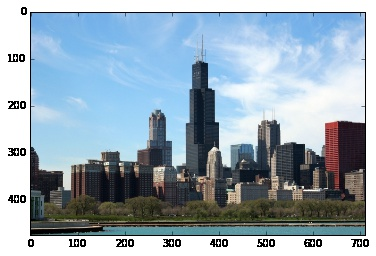

In [78]:
plt.imshow(im)

In [79]:
def stylize(im, params):
    return f(Variable(tr(im)), params)

In [80]:
def load_params(filename, verbose=False):
    params = hkl.load(filename)

    # convert numpy arrays to torch Variables
    for k,v in params.iteritems():
        if verbose:
            print k, v.shape
        params[k] = Variable(torch.from_numpy(v))

    if verbose:
        print '\nTotal parameters:', sum([v.numel() for v in params.itervalues()])
    return params

## wave.hkl

r4.c2.bias (128,)
r2.c1.weight (128, 128, 3, 3)
c1.bias (32,)
r4.c1.bias (128,)
r3.c2.weight (128, 128, 3, 3)
c1.weight (32, 3, 9, 9)
r2.c2.bias (128,)
r5.c2.bias (128,)
r2.c2.weight (128, 128, 3, 3)
r5.c1.bias (128,)
c3.weight (128, 64, 4, 4)
r1.c1.bias (128,)
c3.bias (128,)
r2.c1.bias (128,)
r1.c1.weight (128, 128, 3, 3)
c2.bias (64,)
d2.weight (64, 32, 4, 4)
d3.bias (3,)
d1.bias (64,)
c2.weight (64, 32, 4, 4)
r3.c2.bias (128,)
r1.c2.weight (128, 128, 3, 3)
r5.c2.weight (128, 128, 3, 3)
r5.c1.weight (128, 128, 3, 3)
d1.weight (128, 64, 4, 4)
d3.weight (3, 32, 9, 9)
r4.c1.weight (128, 128, 3, 3)
r4.c2.weight (128, 128, 3, 3)
r3.c1.bias (128,)
r1.c2.bias (128,)
d2.bias (32,)
r3.c1.weight (128, 128, 3, 3)

Total parameters: 1819395


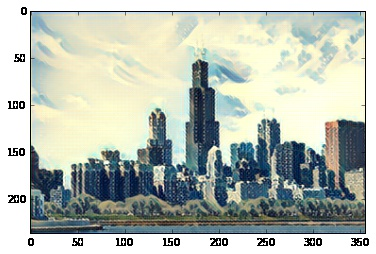

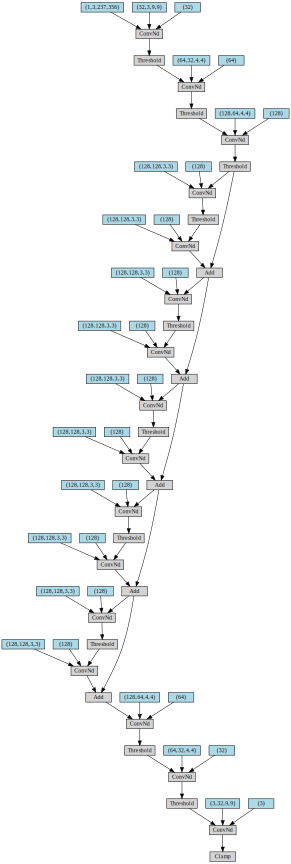

In [81]:
stylized = stylize(im, load_params('wave.hkl', verbose=True))
plt.imshow(tr_backward(stylized.data[0]))
plt.show()
make_dot(stylized)

## feathers.hkl

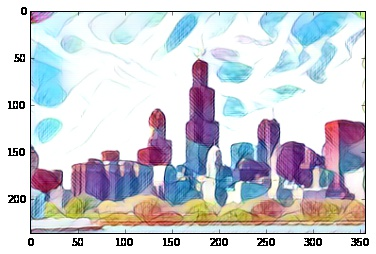

In [82]:
stylized = stylize(im, load_params('feathers.hkl', verbose=False))
plt.imshow(tr_backward(stylized.data[0]))

## candy.hkl

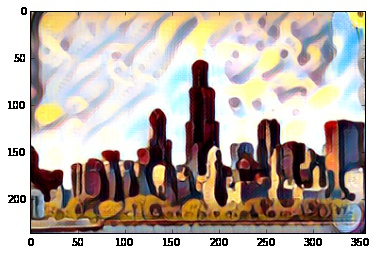

In [83]:
stylized = stylize(im, load_params('candy.hkl', verbose=False))
plt.imshow(tr_backward(stylized.data[0]))